In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
import wget
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
myfile = wget.download(url)

100% [..............................................................................] 67921 / 67921

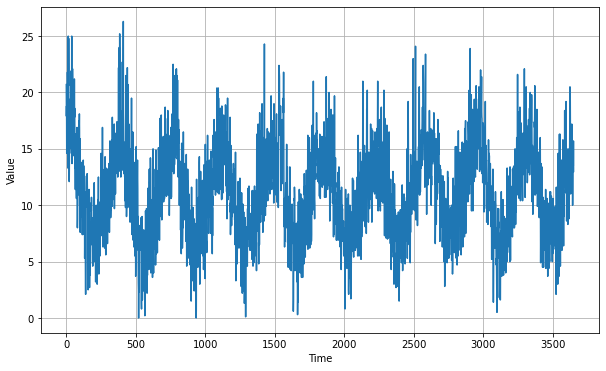

In [5]:
import csv
time_step = []
temps = []

with open('E:\\TensorflowDeveloperCertification\\Tensorflow _Ravi\\Sequences and timeseries/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
temps

[20.7,
 17.9,
 18.8,
 14.6,
 15.8,
 15.8,
 15.8,
 17.4,
 21.8,
 20.0,
 16.2,
 13.3,
 16.7,
 21.5,
 25.0,
 20.7,
 20.6,
 24.8,
 17.7,
 15.5,
 18.2,
 12.1,
 14.4,
 16.0,
 16.5,
 18.7,
 19.4,
 17.2,
 15.5,
 15.1,
 15.4,
 15.3,
 18.8,
 21.9,
 19.9,
 16.6,
 16.8,
 14.6,
 17.1,
 25.0,
 15.0,
 13.7,
 13.9,
 18.3,
 22.0,
 22.1,
 21.2,
 18.4,
 16.6,
 16.1,
 15.7,
 16.6,
 16.5,
 14.4,
 14.4,
 18.5,
 16.9,
 17.5,
 21.2,
 17.8,
 18.6,
 17.0,
 16.0,
 13.3,
 14.3,
 11.4,
 16.3,
 16.1,
 11.8,
 12.2,
 14.7,
 11.8,
 11.3,
 10.6,
 11.7,
 14.2,
 11.2,
 16.9,
 16.7,
 8.1,
 8.0,
 8.8,
 13.4,
 10.9,
 13.4,
 11.0,
 15.0,
 15.7,
 14.5,
 15.8,
 16.7,
 16.8,
 17.5,
 17.1,
 18.1,
 16.6,
 10.0,
 14.9,
 15.9,
 13.0,
 7.6,
 11.5,
 13.5,
 13.0,
 13.3,
 12.1,
 12.4,
 13.2,
 13.8,
 10.6,
 9.0,
 10.0,
 9.8,
 11.5,
 8.9,
 7.4,
 9.9,
 9.3,
 9.9,
 7.4,
 8.6,
 11.9,
 14.0,
 8.6,
 10.0,
 13.5,
 12.0,
 10.5,
 10.7,
 8.1,
 10.1,
 10.6,
 5.3,
 6.6,
 8.5,
 11.2,
 9.8,
 5.9,
 3.2,
 2.1,
 3.4,
 5.4,
 9.6,
 11.5,
 12.3,
 12.6,
 11

In [12]:
len(time_step)

3650

In [13]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 13s 473ms/step - loss: 31.0287 - mae: 31.5267
Epoch 2/100
10/10 [==============================] - 5s 433ms/step - loss: 30.7698 - mae: 31.2675
Epoch 3/100
10/10 [==============================] - 5s 426ms/step - loss: 29.9371 - mae: 30.4346
Epoch 4/100
10/10 [==============================] - 5s 429ms/step - loss: 28.6752 - mae: 29.1725
Epoch 5/100
10/10 [==============================] - 5s 461ms/step - loss: 27.2988 - mae: 27.7959
Epoch 6/100
10/10 [==============================] - 5s 431ms/step - loss: 25.7600 - mae: 26.2569
Epoch 7/100
10/10 [==============================] - 5s 458ms/step - loss: 24.0420 - mae: 24.5383
Epoch 8/100
10/10 [==============================] - 5s 401ms/step - loss: 21.3711 - mae: 21.8673
Epoch 9/100
10/10 [==============================] - 4s 401ms/step - loss: 18.2363 - mae: 18.7317
Epoch 10/100
10

10/10 [==============================] - 4s 361ms/step - loss: 4.5153 - mae: 4.9948
Epoch 85/100
10/10 [==============================] - 4s 364ms/step - loss: 4.9757 - mae: 5.4581
Epoch 86/100
10/10 [==============================] - 4s 370ms/step - loss: 6.3224 - mae: 6.8100
Epoch 87/100
10/10 [==============================] - 4s 375ms/step - loss: 9.3444 - mae: 9.8307
Epoch 88/100
10/10 [==============================] - 4s 363ms/step - loss: 19.1533 - mae: 19.6496
Epoch 89/100
10/10 [==============================] - 4s 365ms/step - loss: 20.1263 - mae: 20.6259
Epoch 90/100
10/10 [==============================] - 4s 367ms/step - loss: 23.5261 - mae: 24.0261
Epoch 91/100
10/10 [==============================] - 4s 356ms/step - loss: 25.2195 - mae: 25.7195
Epoch 92/100
10/10 [==============================] - 4s 365ms/step - loss: 29.0501 - mae: 29.5501
Epoch 93/100
10/10 [==============================] - 4s 391ms/step - loss: 32.2227 - mae: 32.7227
Epoch 94/100
10/10 [===========

(1e-08, 0.0001, 0.0, 60.0)

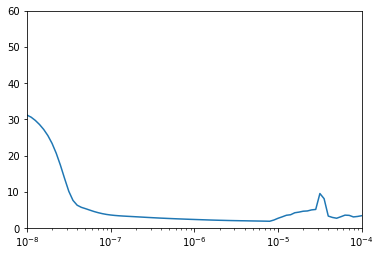

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
25/25 [==============================] - 12s 182ms/step - loss: 15.8473 - mae: 16.3396
Epoch 2/150
25/25 [==============================] - 5s 180ms/step - loss: 2.9314 - mae: 3.3996
Epoch 3/150
25/25 [==============================] - 5s 178ms/step - loss: 2.0152 - mae: 2.4714 3s - loss:
Epoch 4/150
25/25 [==============================] - 5s 187ms/step - loss: 1.9115 - mae: 2.3666
Epoch 5/150
25/25 [==============================] - 5s 181ms/step - loss: 1.8753 - mae: 2.3298 1s - loss: 1.9003 - ma
Epoch 6/150
25/25 [==============================] - 5s 177ms/step - loss: 1.8384 - mae: 2.2917
Epoch 7/150
25/25 [==============================] - 5s 205ms/step - loss: 1.8145 - mae: 2.2668
Epoch 8/150
25/25 [==============================] - 6s 208ms/step - loss: 1.7895 - mae: 2.2405
Epoch 9/150
25/25 [==============================] - 6s 217ms/step - loss: 1.7727 - mae: 2.2239
Epoch 10/150
25/25 [==============================] - 6s 216ms/step - loss: 1.7410 - mae: 2.1911
Ep

25/25 [==============================] - 5s 208ms/step - loss: 1.5416 - mae: 1.9835
Epoch 84/150
25/25 [==============================] - 6s 216ms/step - loss: 1.5353 - mae: 1.9779
Epoch 85/150
25/25 [==============================] - 5s 202ms/step - loss: 1.5359 - mae: 1.9784 0s - loss: 1.5397 - mae: 1.9
Epoch 86/150
25/25 [==============================] - 5s 187ms/step - loss: 1.5328 - mae: 1.9751
Epoch 87/150
25/25 [==============================] - 5s 184ms/step - loss: 1.5347 - mae: 1.9767
Epoch 88/150
25/25 [==============================] - 5s 179ms/step - loss: 1.5338 - mae: 1.9758 2s - loss: 1.5524 -
Epoch 89/150
25/25 [==============================] - 5s 182ms/step - loss: 1.5299 - mae: 1.9721
Epoch 90/150
25/25 [==============================] - 5s 183ms/step - loss: 1.5380 - mae: 1.9803
Epoch 91/150
25/25 [==============================] - 5s 201ms/step - loss: 1.5291 - mae: 1.9712
Epoch 92/150
25/25 [==============================] - 7s 254ms/step - loss: 1.5300 - mae: 1

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

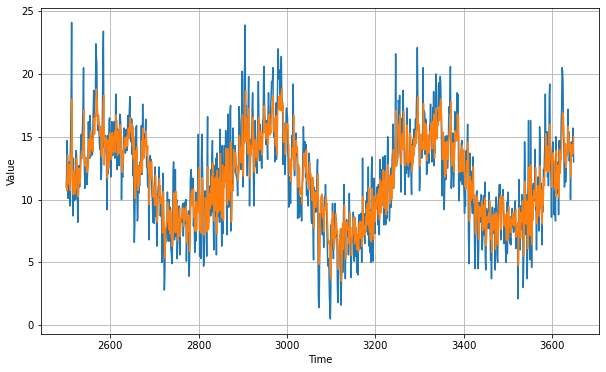

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.7796307

In [22]:
print(rnn_forecast)

[11.327943 10.704968 12.124029 ... 13.604006 13.7961   15.008356]


In [23]:
len(rnn_forecast)

1150

In [26]:
rnn_forecast[split_time - window_size:-1]

array([], dtype=float32)

In [27]:
split_time - window_size

2436

In [29]:
x = (1,2,3,4,5)

In [30]:
x[:-1]

(1, 2, 3, 4)